In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# requisitos
# cargar csv
# usar funciones
# limpieza de datos
# analisis de datos
# tran/vaal/test split
# seleccion variables
# normalizdor
# learning rate
# entrenar modelo
# testear modelo
# guardar modelo y normalizador
# crear archivo py
# crear requerimientos
# crear dockerfile
# crear repo github
# guardar codigo en repo


In [6]:
#cargar csv
raw_df = pd.read_csv('pulsar_stars.csv')

In [7]:
# exploration
cols = raw_df.columns
print(len(cols), cols)

9 Index([' Mean of the integrated profile',
       ' Standard deviation of the integrated profile',
       ' Excess kurtosis of the integrated profile',
       ' Skewness of the integrated profile', ' Mean of the DM-SNR curve',
       ' Standard deviation of the DM-SNR curve',
       ' Excess kurtosis of the DM-SNR curve', ' Skewness of the DM-SNR curve',
       'target_class'],
      dtype='object')


In [8]:
#quick cleanup
# names are too longg, shortening
raw_df.columns = ['ipmean', 'ipsdv', 'ipkurt','ipskew','dmmean', 'dmsdv', 'dmskurt', 'dmskew', 'target' ]
cols = raw_df.columns
# drop null values
raw_df.dropna(inplace=True)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

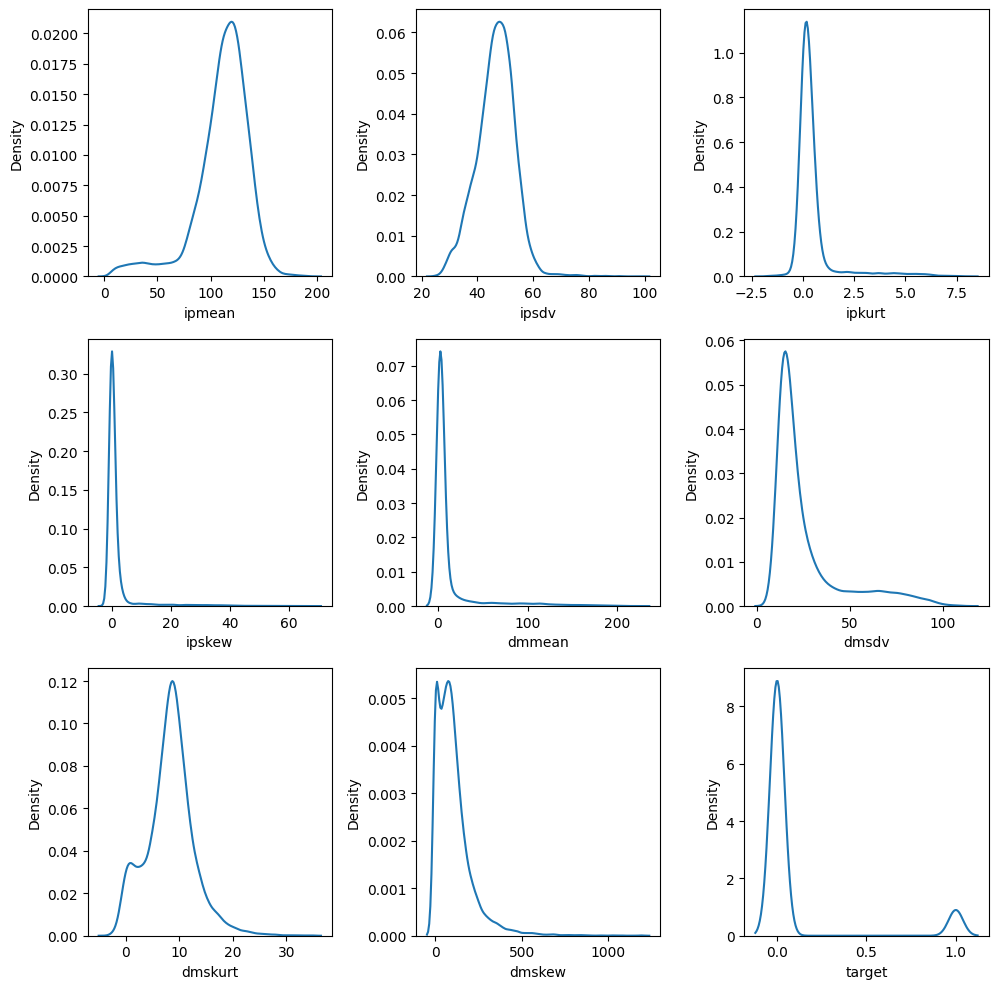

In [9]:
# utilizar funciones
# distribucion de datos
def make_distributions(ncols,nrows):
  n_ccols = ncols
  n_rows = nrows
  fig, ax = plt.subplots(n_rows, n_ccols, figsize=(10,10))
  ax = ax.flatten()

  for i, col in enumerate(cols):
    plt_ax = [ax[i]]

    sns.kdeplot( raw_df[col], ax=ax[i])
  plt.tight_layout()
  return plt

make_distributions(3, 3)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# separate trainig sets
# primero normalizamos valores
scaler = MinMaxScaler()
df_dataset = raw_df.drop(columns='target')
df_norm=scaler.fit_transform(df_dataset)

df_norm = pd.DataFrame(df_norm, columns=df_dataset.columns)

X = df_norm
y =raw_df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)
X_train

,ipmean,ipsdv,ipkurt,ipskew,dmmean,dmsdv,dmskurt,dmskew
2677,0.685166,0.398257,0.186306,0.021399,0.009040,0.059088,0.358474,0.122370
12417,0.645268,0.359952,0.203580,0.022484,0.016271,0.173050,0.270569,0.044639
3272,0.729999,0.431770,0.170192,0.015315,0.039146,0.309175,0.203602,0.018174
9301,0.556313,0.301964,0.230778,0.028881,0.008958,0.110154,0.337291,0.083711
5372,0.573711,0.419634,0.218880,0.022039,0.008789,0.059383,0.340132,0.110246
...,...,...,...,...,...,...,...,...
266,0.664799,0.248888,0.203857,0.025304,0.006328,0.065059,0.408024,0.150128
10394,0.630463,0.299369,0.210839,0.023653,0.003937,0.030975,0.496966,0.262484
1209,0.620969,0.343926,0.204337,0.020857,0.006687,0.061663,0.375736,0.124343
14254,0.642131,0.419847,0.203677,0.019284,0.009239,0.068988,0.348826,0.106400


In [24]:
# entrenar modelo
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score

xgbmodel = xgb.XGBClassifier()
xgbmodel.fit(X_train,y_train)
y_pred = xgbmodel.predict(X_test)
accuracy = accuracy_score(y_pred,y_test)
print(accuracy)

0.979608938547486


In [39]:
#trying lightgbm

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}


epochs = 100
model = lgb.train(params, train_data, epochs, valid_sets=[test_data])

# Make predictions on the test data
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)

import pickle

with open('model_lightbm.pkl', 'wb') as f:
    pickle.dump(model, f)

[LightGBM] [Info] Number of positive: 1306, number of negative: 13012
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 14318, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091214 -> initscore=-2.298903
[LightGBM] [Info] Start training from score -2.298903
Accuracy: 0.9804469273743017


In [38]:
to_test= np.array([[0.685166,	0.398257,	0.186306,	0.021399,	0.009040,	0.059088,	0.358474,	0.122370]])

pred_prob = model.predict(to_test,num_iteration = model.best_iteration)
predicted_label = 1 if pred_prob > 0.5 else 0
print(predicted_label)

0


In [35]:
raw_df.head()

,ipmean,ipsdv,ipkurt,ipskew,dmmean,dmsdv,dmskurt,dmskew,target
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
